In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

In [20]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    return df

In [21]:
# Create sequences for LSTM input
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

In [22]:
# Build the LSTM model
def build_model(input_shape, output_shape):
    model = keras.models.Sequential([
        keras.layers.LSTM(100, activation='relu', input_shape=input_shape, return_sequences=True),
        keras.layers.LSTM(100, activation='relu'),
        keras.layers.Dense(output_shape)  # output units for 31 residents
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [23]:
# Evaluate the model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

In [24]:
# Load and preprocess the data
df = load_and_preprocess_data('data/customer_power_data.csv')
df_reactive = load_and_preprocess_data('data/customer_reactive_power_data.csv')

# Prepare the data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data_reactive = scaler.fit_transform(df_reactive)

# Create sequences
sequence_length = 48  # Use 24 (48 steps/records) hours of data to predict the next half hour
X, y = create_sequences(scaled_data, sequence_length)
X_reactive, y_reactive = create_sequences(scaled_data_reactive, sequence_length)

# Build and train the model
model = build_model((X.shape[1], X.shape[2]), df.shape[1])
model_reactive = build_model((X_reactive.shape[1], X_reactive.shape[2]), df_reactive.shape[1])
history = model.fit(X, y, epochs=20, batch_size=32, verbose=1)
history_reactive = model_reactive.fit(X_reactive, y_reactive, epochs=20, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X)
predictions_reactive = model_reactive.predict(X_reactive)

# Evaluate the model
evaluate_model(y, predictions)
evaluate_model(y_reactive, predictions_reactive)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
predictions_reactive = scaler.inverse_transform(predictions_reactive)
y = scaler.inverse_transform(y)
y_reactive = scaler.inverse_transform(y_reactive)

c:\Users\cxlan\Source\Repos\FEIT-Hackathon-2024\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - loss: 0.0089
Epoch 2/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 0.0062
Epoch 3/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.0052
Epoch 4/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 0.0048
Epoch 5/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 0.0045
Epoch 6/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 0.0044
Epoch 7/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0043
Epoch 8/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - loss: 0.0043
Epoch 9/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.0043
Epoch 10/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0042
Epoch 11/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.0042
Epoch 12/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.0042
Epoch 13/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - loss: 0.0041
Epoch 14/20
546/546 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - loss: 0.0041
Epoch 15/20
546/546 ━━━━━━━━━

In [25]:
# Save the model
model.save('model.h5')
model_reactive.save('model_reactive.h5')

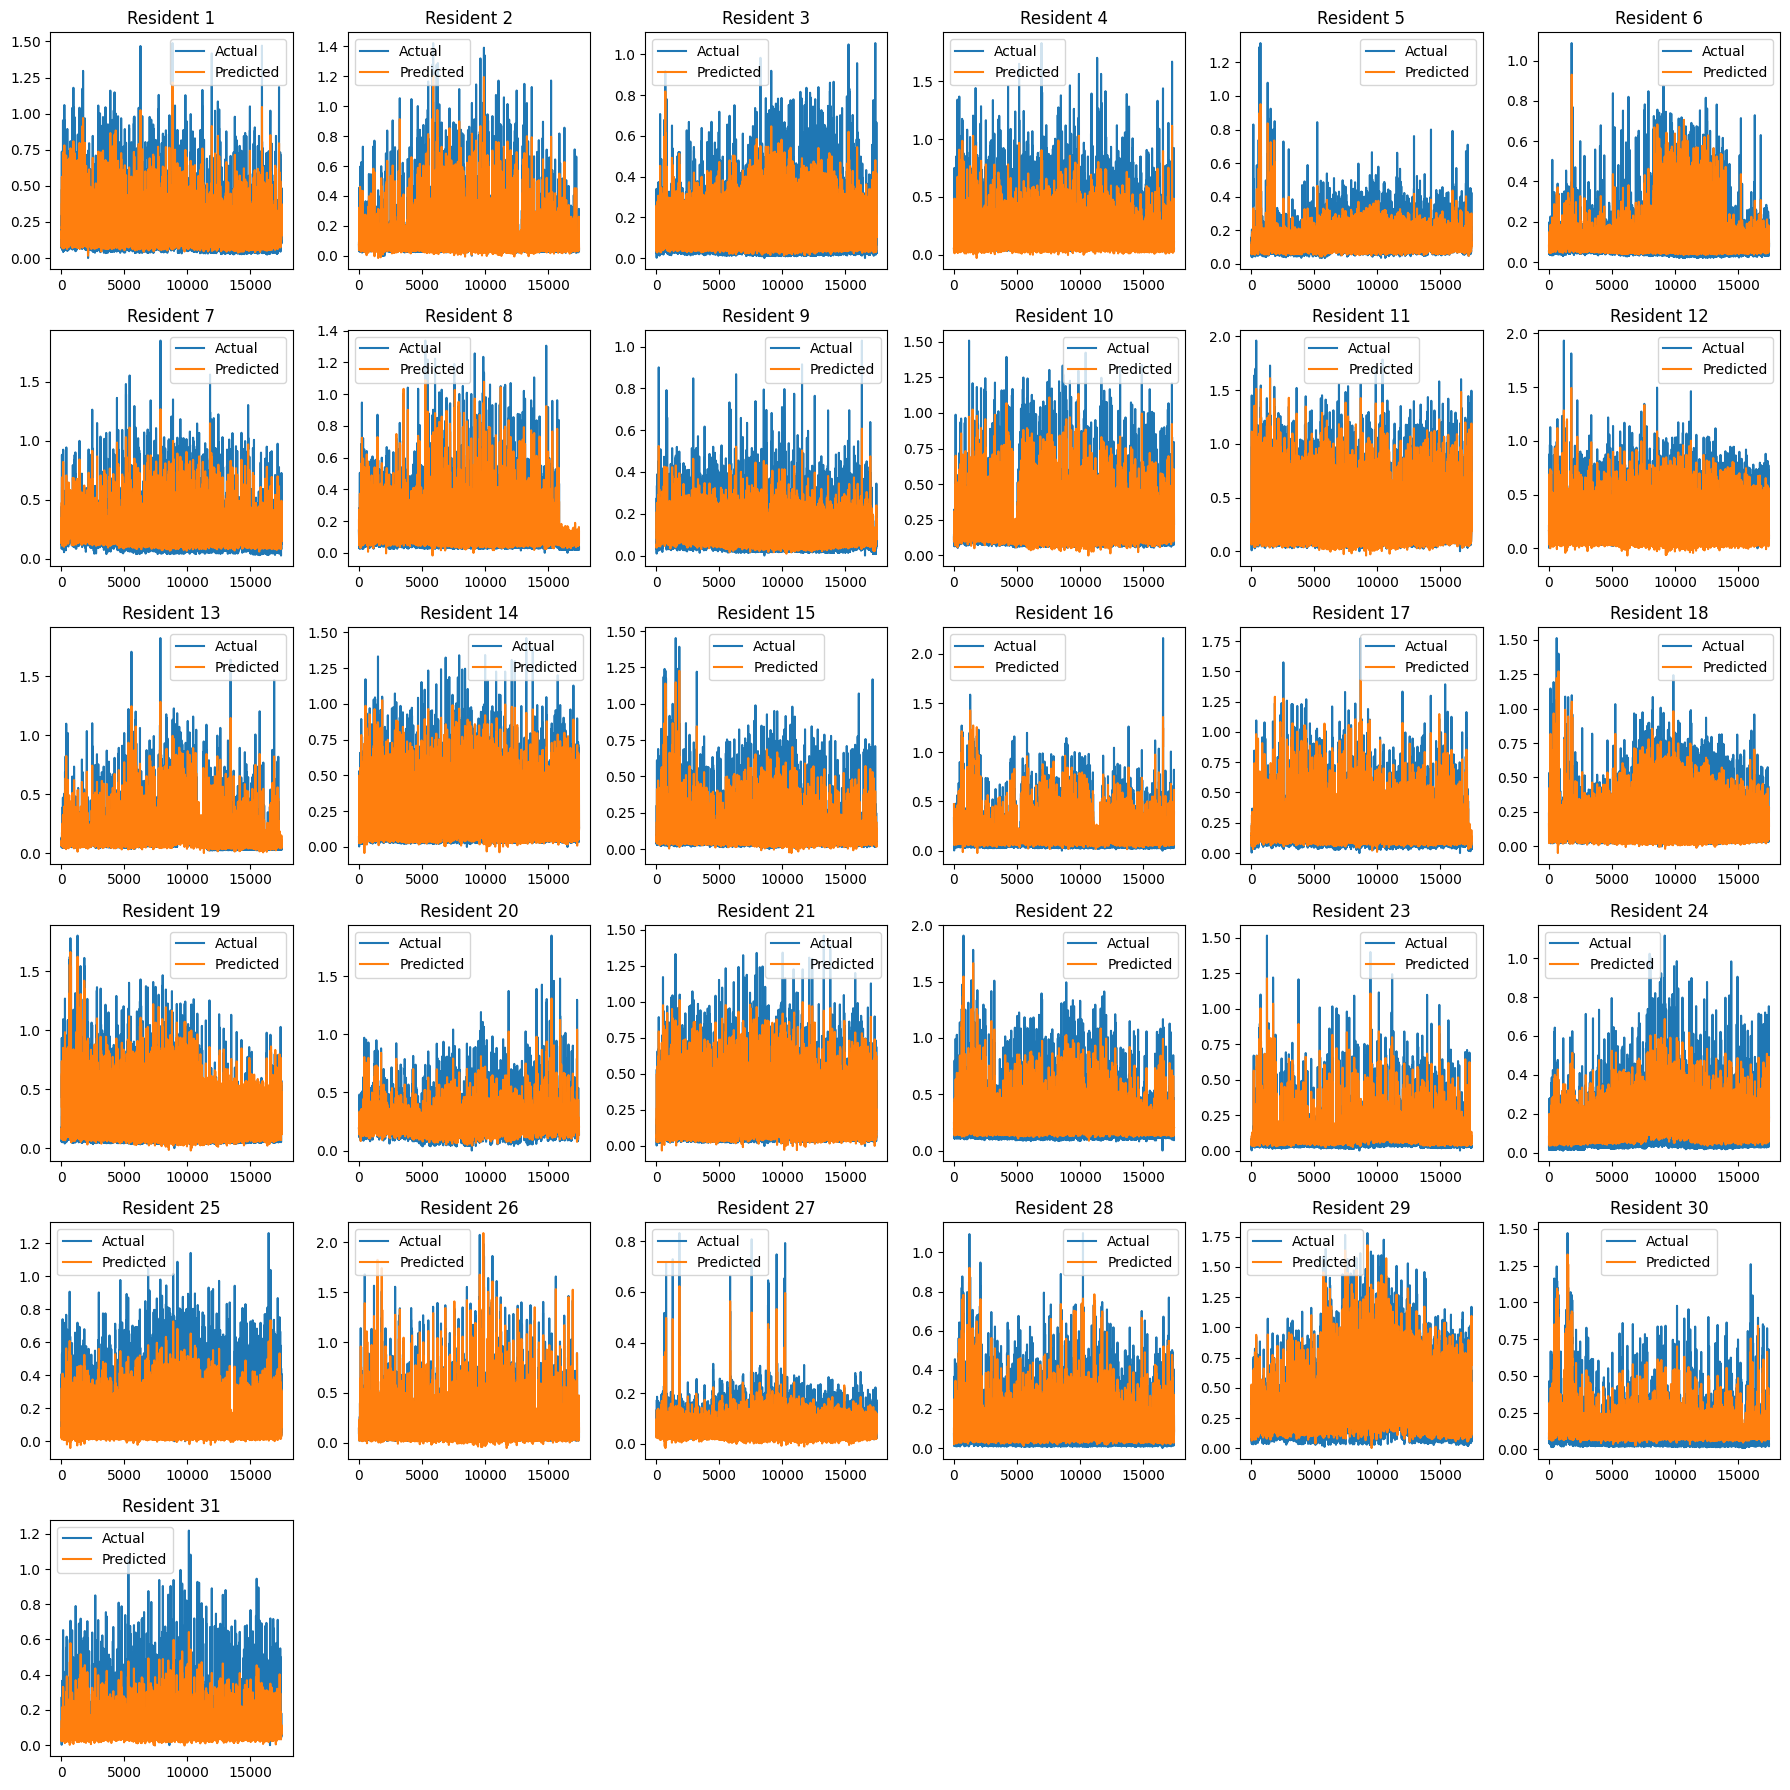

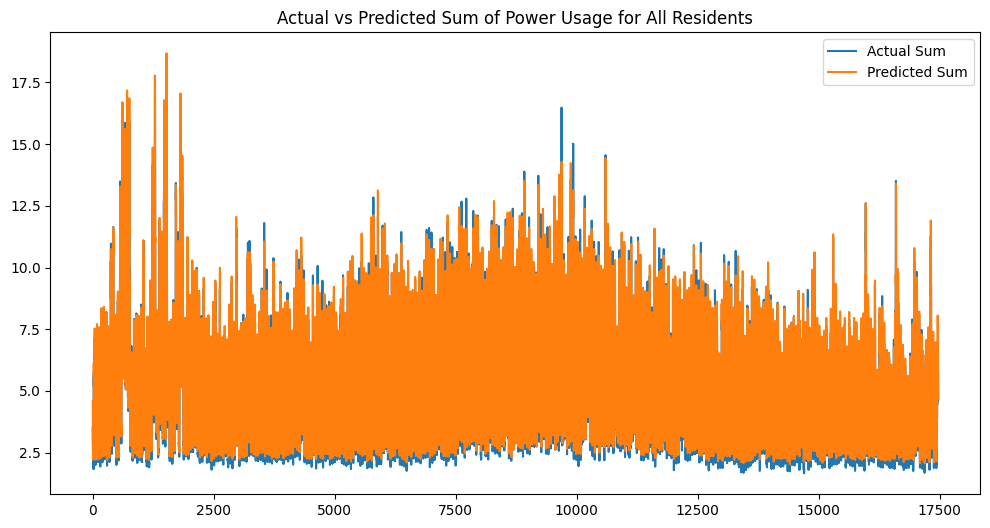

In [42]:
# Plot the results for all residents
num_residents = y.shape[1]
residents_per_row = 6
num_rows = (num_residents + residents_per_row - 1) // residents_per_row

plt.figure(figsize=(18, 3 * num_rows))
for i in range(num_residents):
    if i == 31:    # No need to draw year, month and day
        break
    plt.subplot(num_rows, residents_per_row, i + 1)
    plt.plot(y[:, i], label='Actual')
    plt.plot(predictions[:, i], label='Predicted')
    plt.legend()
    plt.title(f'Resident {i+1}')
plt.tight_layout()
plt.show()

# Calculate and print the sum of predictions for all residents
sum_predictions = np.sum(predictions, axis=1)
sum_actual = np.sum(y, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(sum_actual, label='Actual Sum')
plt.plot(sum_predictions, label='Predicted Sum')
plt.legend()
plt.title('Actual vs Predicted Sum of Power Usage for All Residents')
plt.show()

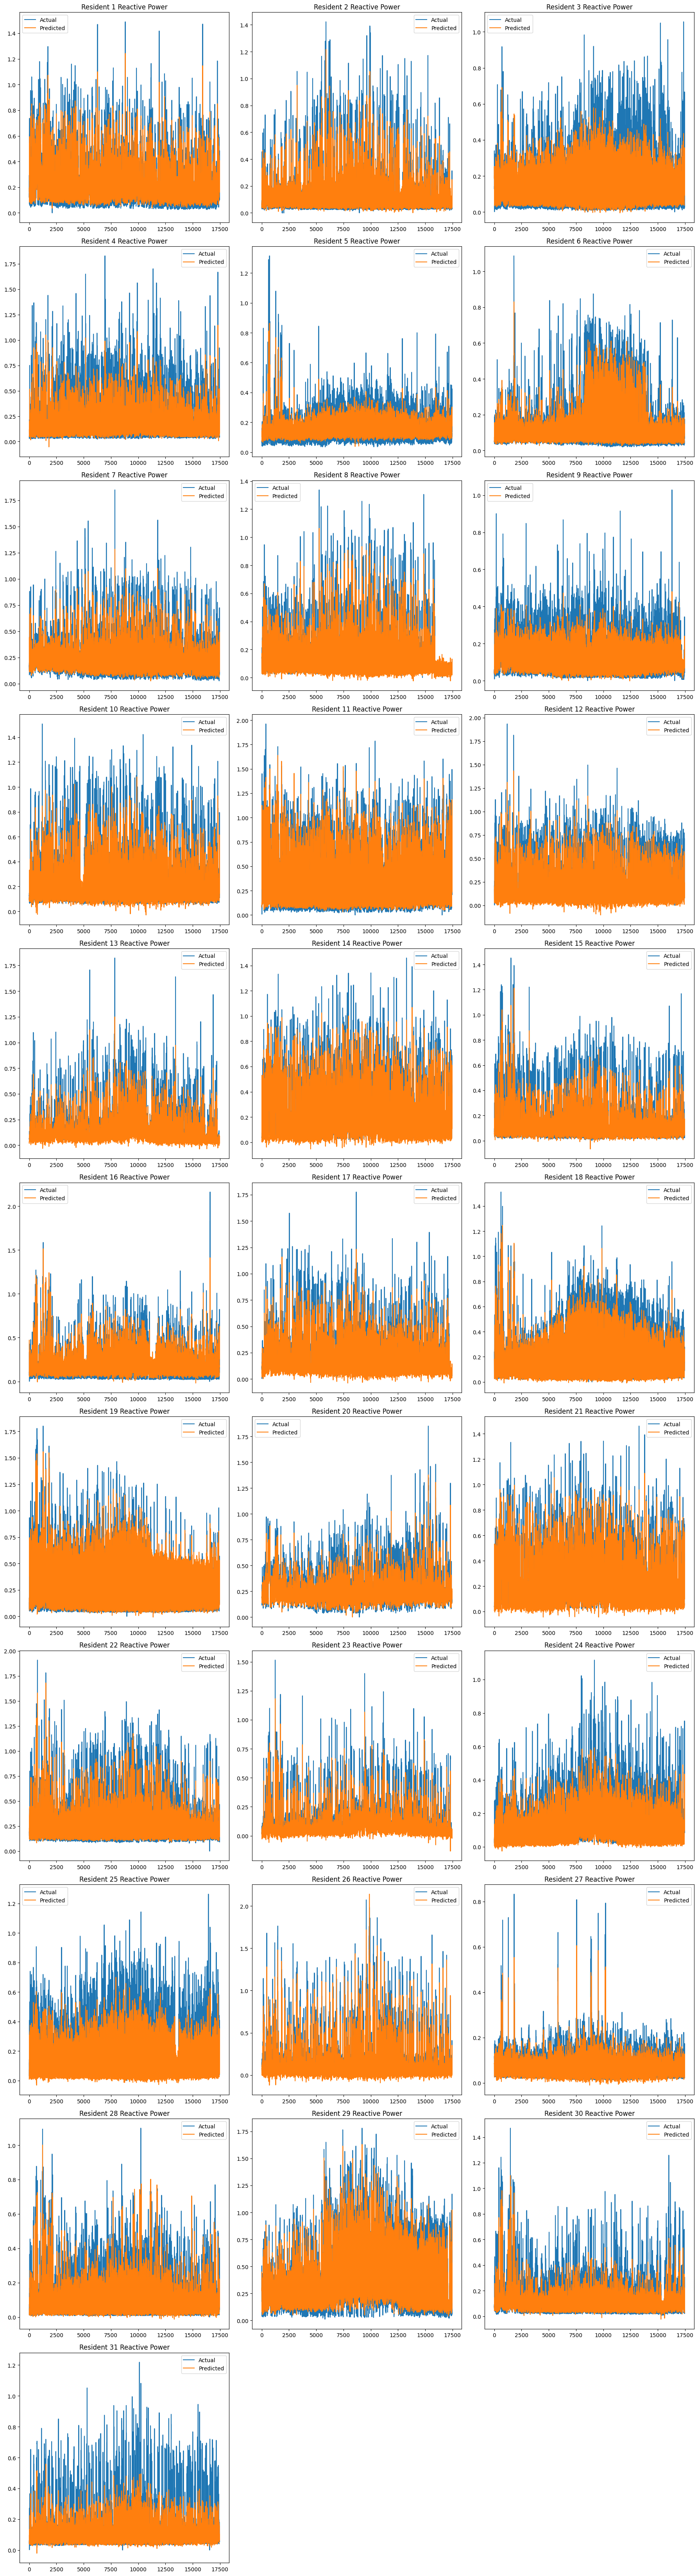

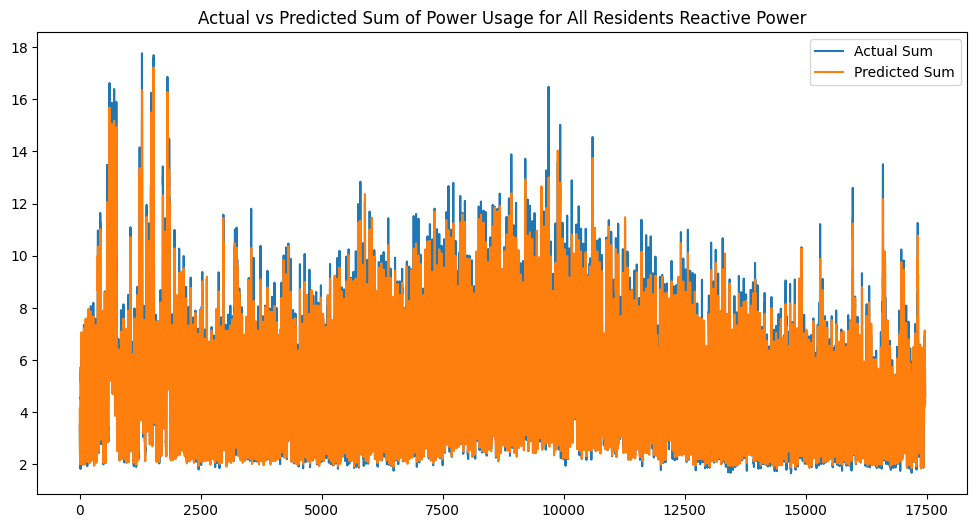

In [27]:
# Plot the results for all residents reactive power
num_residents = y_reactive.shape[1]
residents_per_row = 6
num_rows = (num_residents + residents_per_row - 1) // residents_per_row

plt.figure(figsize=(18, 3 * num_rows))
for i in range(num_residents):
    if i == 31:    # No need to draw year, month and day
        break
    plt.subplot(num_rows, residents_per_row, i + 1)
    plt.plot(y_reactive[:, i], label='Actual')
    plt.plot(predictions_reactive[:, i], label='Predicted')
    plt.legend()
    plt.title(f'Resident {i+1} Reactive Power')
plt.tight_layout()
plt.show()

# Calculate and print the sum of predictions for all residents
sum_predictions = np.sum(predictions_reactive, axis=1)
sum_actual = np.sum(y_reactive, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(sum_actual, label='Actual Sum')
plt.plot(sum_predictions, label='Predicted Sum')
plt.legend()
plt.title('Actual vs Predicted Sum of Power Usage for All Residents Reactive Power')
plt.show()

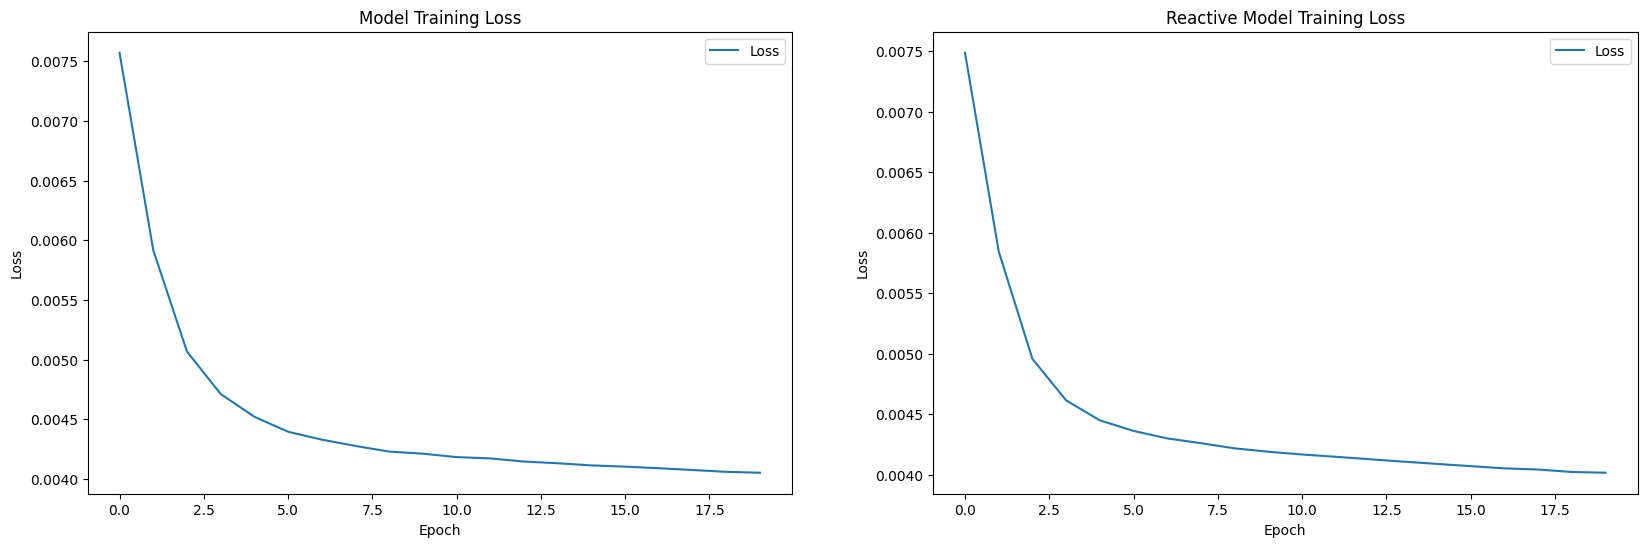

In [37]:
# Plot the loss curve
def plot_loss_curve(history, title, ax):
    ax.plot(history.history['loss'], label='Loss')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plot_loss_curve(history, 'Model Training Loss', axs[0])
plot_loss_curve(history_reactive, 'Reactive Model Training Loss', axs[1])
plt.show()